In [1]:
import numpy as np
import pandas as pd

import math
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

## Import Data

In [2]:
data = pd.read_csv('emails.csv')

In [3]:
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
text    5728 non-null object
spam    5728 non-null int64
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [7]:
df = data.copy()

## EDA

### Have a look at label distribution to check whether data is imbalanced

In [8]:
df.spam.value_counts()

0    4360
1    1368
Name: spam, dtype: int64

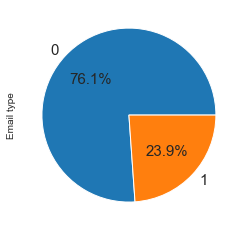

In [9]:
df.spam.value_counts().plot.pie(fontsize=15, autopct='%1.1f%%')
plt.ylabel('Email type')
plt.rcParams['font.size'] = 20

### Have a look at contents of spam and ham emails

In [21]:
df.text[df.spam == 1][0]

"Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordability : your  ma

In [24]:
df.text[df.spam == 0][1368]

'Subject: hello guys ,  i \' m " bugging you " for your completed questionnaire and for a one - page  bio / statement on your thoughts on " business edu and the new economy " . if  my records are incorrect please re - ship your responses to me . i want to  put everything together next week so that i can ship it back to everyone .  the questionnaire is attached as well as copies of the bio pages for  michael froehls and myself ( two somewhat different approaches ) . the idea  of the latter is just to introduce yourself to the other panelists and give  them some background on how you are approaching the issues we will discuss .  we will also provide copies to the attendees and use this material for our  personal introductions at the opening of the panel discussions .  thanks and i look forward to seeing you in two weeks .  john  - waco _ background _ mf . doc  - jmartinbiosketch . doc  - questionnaire . doc  john d . martin  carr p . collins chair in finance  finance department  baylor u

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
import re

from wordcloud import WordCloud, STOPWORDS

In [16]:
def stem_tokenizer(text):
    stemmer = EnglishStemmer(ignore_stopwords=True)
    words = re.sub(r"[^A-Za-z0-9\-]", " ", text).lower().split()
    words = [stemmer.stem(word) for word in words]
    return words 

In [28]:
stem_tokenizer(df.text[0])

['subject',
 'natur',
 'irresist',
 'your',
 'corpor',
 'ident',
 'lt',
 'is',
 'realli',
 'hard',
 'to',
 'recollect',
 'a',
 'compani',
 'the',
 'market',
 'is',
 'full',
 'of',
 'suqgest',
 'and',
 'the',
 'inform',
 'isoverwhelminq',
 'but',
 'a',
 'good',
 'catchi',
 'logo',
 'stylish',
 'statloneri',
 'and',
 'outstand',
 'websit',
 'will',
 'make',
 'the',
 'task',
 'much',
 'easier',
 'we',
 'do',
 'not',
 'promis',
 'that',
 'havinq',
 'order',
 'a',
 'iogo',
 'your',
 'compani',
 'will',
 'automaticaili',
 'becom',
 'a',
 'world',
 'ieader',
 'it',
 'isguit',
 'ciear',
 'that',
 'without',
 'good',
 'product',
 'effect',
 'busi',
 'organ',
 'and',
 'practic',
 'aim',
 'it',
 'will',
 'be',
 'hotat',
 'nowaday',
 'market',
 'but',
 'we',
 'do',
 'promis',
 'that',
 'your',
 'market',
 'effort',
 'will',
 'becom',
 'much',
 'more',
 'effect',
 'here',
 'is',
 'the',
 'list',
 'of',
 'clear',
 'benefit',
 'creativ',
 'hand',
 '-',
 'made',
 'origin',
 'logo',
 'special',
 'done'

In [98]:
def word_cloud_plot(s, title):
    '''Parameter s: array 
                 title: string, the plot name
    Output wordcloud'''
    
    text = ''
    
    for value in s:
        words = stem_tokenizer(value)
#         print(index, words)
        words = " ".join(words)
        text = text + words + ' '
        
#     morestop = ['subject','one','will','us','need','ect','hou','kaminski','vinc']
    morestop = []
    morestop = morestop + list(STOPWORDS)
    
    wordcloud = WordCloud(#width = 600, height = 600, 
                    background_color ='white', 
                    stopwords = morestop, 
                    min_font_size = 10).generate(text) 

    # plot the WordCloud image                        
    plt.figure(figsize = (6, 6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.title(title)
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

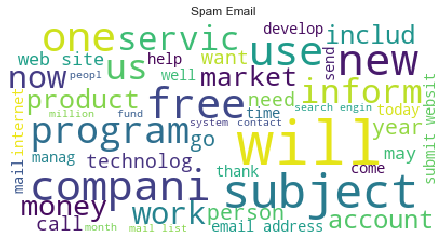

In [99]:
s = df.text[df.spam == 1].values
word_cloud_plot(s, 'Spam Email')

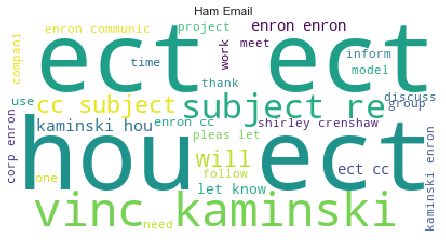

In [100]:
s = df.text[df.spam == 0].values
word_cloud_plot(s, 'Ham Email')

## Model implementation 

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [12]:
X = df["text"] # Note that it is a Series rather than a DataFrame here
y = df['spam']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Bernouli Naive Bayes

In [14]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

* __CountVector + BernoulliNB__

In [17]:
cv = CountVectorizer(stop_words=stopwords.words('english'),
                     tokenizer=stem_tokenizer,
                     lowercase=True,
                     max_df=0.5,
                     min_df=5,
                     ngram_range=(1, 3),
                     binary=True
                    )

In [18]:
tfidf_transformer = TfidfTransformer()

In [19]:
nbclassifier = Pipeline([('cv', cv), ('nb', BernoulliNB())])

In [20]:
nbclassifier = nbclassifier.fit(X_train, y_train)

In [21]:
print(classification_report(y_test, nbclassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1314
           1       0.90      0.99      0.94       405

    accuracy                           0.97      1719
   macro avg       0.95      0.98      0.96      1719
weighted avg       0.97      0.97      0.97      1719



In [22]:
from sklearn.metrics import roc_curve,roc_auc_score

In [24]:
y_test_proba = nbclassifier.predict_proba(X_test)
y_test_proba

array([[1.00000000e+000, 6.10118357e-173],
       [1.00000000e+000, 4.91093332e-036],
       [3.04816398e-168, 1.00000000e+000],
       ...,
       [1.00000000e+000, 1.43071496e-075],
       [1.00000000e+000, 3.63511293e-022],
       [1.00000000e+000, 3.99144303e-032]])

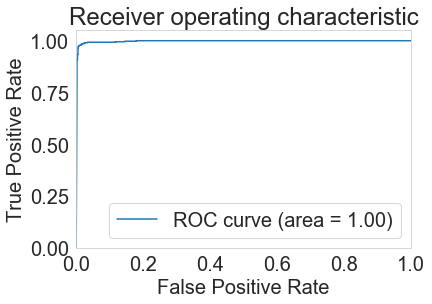

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
plt.plot(fpr, tpr, label='ROC curve (area = {0:.2f})'.format(roc_auc_score(y_test, y_test_proba[:,1])))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.grid()
plt.legend(loc="lower right")

* TFIDF + BernoulliNB

In [101]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'),
                        tokenizer=stem_tokenizer,
                        lowercase=True,
                        max_df=0.8,
                        min_df=5,
                        ngram_range=(1, 3)
                       )

In [102]:
nbclassifier = Pipeline([('tfidf', tfidf), ('nb', BernoulliNB())])

In [103]:
nbclassifier = nbclassifier.fit(X_train, y_train)

In [104]:
print(classification_report(y_test, nbclassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1314
           1       0.90      0.99      0.94       405

    accuracy                           0.97      1719
   macro avg       0.95      0.98      0.96      1719
weighted avg       0.97      0.97      0.97      1719



In [105]:
grams = [''] * len(nbclassifier['tfidf'].vocabulary_)
for k, v in nbclassifier['tfidf'].vocabulary_.items():
    grams[v] = k
    print(v,k,grams[v])

9171 confirm confirm
6530 attend attend
0 - -
21520 oct oct
2766 19 19
2935 20 20
31774 wharton wharton
30894 vinc vinc
10528 delight delight
8341 christi christi
23359 possibl possibl
19425 mark mark
22230 palmer palmer
30398 upcom upcom
16146 impact impact
9118 confer confer
21531 octob octob
13569 final final
5590 agenda agenda
12161 enclos enclos
22952 pleas pleas
21348 note note
30357 unless unless
15359 hear hear
22076 otherwis otherwis
6468 assum assum
10876 dinner dinner
29558 time time
12990 event event
14533 generat generat
12334 enorm enorm
16635 interest interest
18730 look look
13981 forward forward
22326 particip particip
15692 hope hope
13659 find find
30705 valuabl valuabl
16556 insight insight
7414 build build
13154 experi experi
7644 call call
11349 e e
19003 mail mail
24352 question question
6393 aspect aspect
5752 also also
27906 stori stori
13177 exploit exploit
24724 recent recent
30029 trip trip
23281 poland poland
20738 must must
13232 extrem extrem
7035 best be

26017 sansom street sansom street
9131 confer held confer held
543 - dietrich - dietrich
10828 dietrich hall dietrich hall
18639 locust walk locust walk
29938 train station train station
29172 th street th street
30102 turn left turn left
25639 right - right -
28965 tel 215 tel 215
3408 215 - 215 -
192 - 222 - 222
3444 222 - 222 -
810 - mention - mention
25841 room rate room rate
24531 rate pleas rate pleas
23062 pleas make pleas make
19194 make reserv make reserv
2637 15 minut 15 minut
29784 tomczyk manag tomczyk manag
19258 manag director manag director
10925 director emerg director emerg
28943 technolog manag technolog manag
19316 manag research manag research
25291 research program research program
23991 program 1400 program 1400
2605 1400 sh 1400 sh
26726 sh - sh -
540 - dh - dh
10806 dh 6371 dh 6371
4649 6371 wharton 6371 wharton
26145 school philadelphia school philadelphia
22179 pa 19104 pa 19104
2797 19104 - 19104 -
328 - 6371 - 6371
4647 6371 tel 6371 tel
310 - 573 - 573
4535

8719 com select perform com select perform
26392 select perform review select perform review
22620 perform review perform perform review perform
25546 review perform review review perform review
22621 perform review servic perform review servic
25556 review servic may review servic may
26636 servic may begin servic may begin
19706 may begin provid may begin provid
6959 begin provid feedback begin provid feedback
24182 provid feedback immedi provid feedback immedi
13466 feedback immedi request feedback immedi request
16138 immedi request feedback immedi request feedback
25159 request feedback form request feedback form
13462 feedback form complet feedback form complet
13928 form complet friday form complet friday
9039 complet friday novemb complet friday novemb
14257 friday novemb 17 friday novemb 17
21408 novemb 17 2000 novemb 17 2000
2713 17 2000 question 17 2000 question
3179 2000 question regard 2000 question regard
24386 question regard pep question regard pep
24880 regard pep resp

30055 trust trust
6810 bank bank
18432 limit limit
4918 80 80
15331 haymarket haymarket
28669 swli swli
28881 te te
20627 mr mr
5692 alexand alexand
14560 georg georg
5265 account account
20581 morri morri
29461 thompson thompson
10824 die die
22927 plane plane
9808 crash crash
5661 airlin airlin
13793 flight flight
17121 januari januari
5729 along along
31844 wife wife
10239 daughter daughter
15267 happen happen
21210 next next
17691 kin kin
30450 us us
31150 visit visit
27118 site site
27080 sinc sinc
14925 got got
16391 inform inform
10397 death death
13130 expect expect
24964 relat relat
8788 come come
8418 claim claim
20481 money money
7774 cannot cannot
24998 releas releas
27317 somebodi somebodi
6121 appli appli
10415 deceas deceas
16319 indic indic
15181 guidelin guidelin
27598 stand stand
29977 trap trap
18161 legal legal
22248 paper paper
28802 taken taken
7817 care care
13361 favor favor
11040 dispos dispos
17245 jo jo
25370 respond respond
27343 soon soon
27091 sincer since

9842 credit credit
23754 prior prior
14114 four four
6817 banker banker
27500 spent spent
26681 seven seven
24922 regist regist
26244 secur secur
23746 princip princip
25480 retail retail
5346 addit addit
14800 global risk global risk
25698 risk manag risk manag
19297 manag oper manag oper
26457 send inform send inform
16481 inform regard inform regard
24968 relat initi relat initi
32086 work last work last
18026 last year last year
12775 enterpris - enterpris -
1094 - wide - wide
31837 wide risk wide risk
7519 busi risk busi risk
8937 compani hope compani hope
15088 group help group help
6173 approach problem approach problem
23822 problem pleas problem pleas
23056 pleas let pleas let
18210 let know let know
17842 know thought know thought
30932 vinc enron vinc enron
12625 enron north enron north
21327 north america north america
5854 america corp america corp
25631 rick causey rick causey
7920 causey enron causey enron
12353 enron 01 enron 01
1284 01 17 01 17
3033 2000 06 2000 06
166

30307 univers univers
30975 vinc kaminski vinc kaminski
17290 john martin john martin
18063 laura stark laura stark
10374 dear friend dear friend
16485 inform relat inform relat
9638 corpor financ corpor financ
13595 financ confer financ confer
19685 may 4 may 4
4019 4 - 4 -
23040 pleas hesit pleas hesit
15528 hesit contact hesit contact
21757 one us one us
30503 us may us may
26854 sheridan titman sheridan titman
29707 titman mail titman mail
19089 mail utexa mail utexa
30650 utexa edu utexa edu
4780 713 348 713 348
25585 rice edu rice edu
11092 doc prof doc prof
23924 prof david prof david
10259 david ikenberri david ikenberri
16092 ikenberri jone ikenberri jone
17333 jone graduat jone graduat
19318 manag rice manag rice
25602 rice univers rice univers
30310 univers 713 univers 713
4771 713 - 713 -
230 - 348 - 348
3923 348 - 348 -
306 - 5385 - 5385
19686 may 4 - may 4 -
4020 4 - 5 4 - 5
24381 question pleas hesit question pleas hesit
23042 pleas hesit contact pleas hesit contact
2970

13403 fax us fax us
14608 get free get free
14195 free secur free secur
26269 secur onlin secur onlin
21785 onlin email onlin email
12030 email http email http
15939 http www http www
32450 www ziplip www ziplip
32654 ziplip com ziplip com
8608 com - com -
5097 949 813 2241 949 813 2241
14610 get free secur get free secur
14196 free secur onlin free secur onlin
26270 secur onlin email secur onlin email
21786 onlin email http onlin email http
12031 email http www email http www
15957 http www ziplip http www ziplip
32451 www ziplip com www ziplip com
32655 ziplip com - ziplip com -
14389 fyi fyi
3621 28 28
31746 wendi wendi
6324 arthurandersen arthurandersen
4161 43 43
27383 sort sort
27324 someth someth
9154 confidenti confidenti
13890 footer footer
23781 privileg privileg
9357 contain contain
5416 addresse addresse
22651 person person
6062 anyon anyon
7866 case case
10714 destroy destroy
17693 kind kind
21384 notifi notifi
26483 sender sender
5531 advis advis
9226 consent consent
2185

26560 sent tuesday sent tuesday
30066 tuesday april tuesday april
6233 april 24 april 24
3507 24 2001 24 2001
3289 2001 5 2001 5
4306 5 31 5 31
3856 31 pm 31 pm
31457 watson kimber watson kimber
7958 cc krishnarao cc krishnarao
17889 krishnarao pinnamaneni krishnarao pinnamaneni
28883 teach class teach class
8428 class rice class rice
26554 sent resum sent resum
25400 respons post respons post
17259 job vinc job vinc
17459 kaminski - kaminski -
14094 forward vinc forward vinc
11472 ect 04 ect 04
1633 04 24 04 24
3234 2001 05 2001 05
1728 05 27 05 27
3612 27 pm 27 pm
15419 helen demianenko helen demianenko
3215 2001 02 2001 02
1392 02 11 02 11
2325 11 05 11 05
1747 05 pm 05 pm
23224 pm pleas pm pleas
25371 respond cc respond cc
10386 dear vinc dear vinc
31080 vinc thank vinc thank
29331 thank talk thank talk
28826 talk morn talk morn
5919 analyst posit analyst posit
13676 find job find job
17249 job descript job descript
10664 descript posit descript posit
23321 posit also posit also
10

9919 crude crude
21338 northwest northwest
7315 brent brent
13812 fob fob
7212 bonni bonni
18341 light light
27111 singapor singapor
11305 dubai dubai
9943 cst cst
6699 averag averag
22626 period period
5257 accompani accompani
7321 brief brief
8842 commentari commentari
9771 cours cours
13447 fee fee
22470 payabl payabl
12830 equal equal
16558 instal instal
3398 212 212
3481 230 230
3950 355 355
13150 expens expens
21195 newslett newslett
10657 describ describ
8277 cheap cheap
30538 usd usd
17444 k k
29542 thx thx
3935 35 35
8276 chat chat
30400 updat updat
13811 fo fo
17441 justif justif
24116 prompt prompt
13322 far far
11411 east east
23881 produc produc
25896 run run
27484 spectrum spectrum
15293 hard hard
9231 consid consid
24753 recommend recommend
8580 colleagu colleagu
30654 util util
12203 ene ene
30690 valid valid
13194 exposur exposur
3985 38 38
4448 53 53
25992 sampl sampl
1375 02 03 02 03
1511 03 2000 03 2000
1500 03 15 03 15
2640 15 pm 15 pm
11193 doug leach doug leach
1

2749 18 pm 18 pm
1596 04 11 04 11
2357 11 2001 11 2001
3271 2001 11 2001 11
2344 11 18 11 18
15422 hello dear hello dear
31026 vinc nice vinc nice
21259 nice meet nice meet
19955 meet talk meet talk
2842 1999 work 1999 work
32140 work two work two
32552 year lead year lead
19268 manag energi manag energi
19286 manag inc manag inc
10774 develop implement develop implement
19621 mathemat model mathemat model
20399 model trade model trade
21913 optim system optim system
23905 product industri product industri
11321 duke energi duke energi
27036 sign contract sign contract
9422 contract buy contract buy
7561 buy product buy product
5812 also sign also sign
9420 contract accord contract accord
25965 sale depart sale depart
23413 potenti market potenti market
19451 market buy market buy
23897 product exceed product exceed
8960 compani one compani one
21756 one two one two
16050 ideal place ideal place
10766 develop effort develop effort
9152 confid make confid make
19200 make signific make s

11451 ect 01 ect 01
1407 02 20 02 20
2969 20 pm 20 pm
17461 kaminski 01 kaminski 01
2360 11 21 11 21
5668 al arfsten al arfsten
18153 left messag left messag
31263 voic mail voic mail
2342 11 16 11 16
31228 vkamin enron vkamin enron
31075 vinc suggest vinc suggest
16813 introduc concept introduc concept
15727 hope would hope would
32305 would mean would mean
12468 enron could enron could
4794 713 965 713 965
14737 give name refer give name refer
4790 713 853 - 713 853 -
15769 hou ect 01 hou ect 01
11462 ect 01 24 ect 01 24
1316 01 24 2001 01 24 2001
1409 02 20 pm 02 20 pm
2970 20 pm - 20 pm -
17038 j kaminski 01 j kaminski 01
3276 2001 11 21 2001 11 21
8015 cc subject next cc subject next
3273 2001 11 16 2001 11 16
31229 vkamin enron com vkamin enron com
18455 line line
9000 compens compens
13912 forget forget
21668 old old
14868 gone gone
31491 wear wear
27581 stabl stabl
6633 automat automat
10441 decid decid
16378 info info
27060 simpl simpl
23422 power power
7171 blank blank
6990 b

17945 lacima lacima
10334 de de
21487 nymex nymex
6255 aram aram
27291 sogomonian sogomonian
22692 peter peter
28643 sven sven
22743 phil phil
13239 eydeland eydeland
27646 stanley stanley
30159 txu txu
16871 invit invit
22310 parti parti
13951 formal formal
24577 reach reach
13764 fitzgerald fitzgerald
28274 subject powerisk subject powerisk
2982 2000 - 2000 -
16379 info - info -
12402 enron capit enron capit
7803 capit trade capit trade
29905 trade resourc trade resourc
25353 resourc corp resourc corp
2372 11 29 11 29
8340 chris strickland chris strickland
14518 geman dauphin geman dauphin
10241 dauphin fr dauphin fr
8773 com vkaminski com vkaminski
8692 com mark com mark
13408 fea com fea com
22715 pge com pge com
15211 haa berkeley haa berkeley
7019 berkeley edu berkeley edu
17946 lacima co lacima co
8548 co uk co uk
8662 com david com david
6256 aram sogomonian aram sogomonian
584 - europ - europ
5693 alexand eydeland alexand eydeland
10371 dear colleagu dear colleagu
23023 pleas 

19117 mailto vinc j mailto vinc j
8726 com sent wednesday com sent wednesday
7790 cantekin mail utexa cantekin mail utexa
30653 utexa edu cc utexa edu cc
11786 edu cc vinc edu cc vinc
30911 vinc cantekin dincerl vinc cantekin dincerl
1529 03 28 2000 03 28 2000
3633 28 2000 11 28 2000 11
4451 53 pleas respond 53 pleas respond
11835 edu vkamin ect edu vkamin ect
31227 vkamin ect enron vkamin ect enron
11628 ect enron com ect enron com
8643 com cc bcc com cc bcc
7935 cc bcc vinc cc bcc vinc
6908 bcc vinc j bcc vinc j
15784 hou ect subject hou ect subject
11714 ect subject summer ect subject summer
28499 summer internship hi summer internship hi
32375 write time inquir write time inquir
28505 summer research group summer research group
25255 research group discuss research group discuss
11928 elba elba
16966 island island
26833 sheet sheet
8274 charter charter
24570 rd rd
13702 finish finish
17342 jose jose
28484 summari attach summari attach
11929 elba island elba island
21938 option cont

8401 circuit circuit
20035 merit merit
30276 unexpect unexpect
10744 determin determin
22929 plant plant
18111 lean lean
15397 heavili heavili
10521 delet delet
26571 sentenc sentenc
5852 amend amend
24970 relat market relat market
30953 vinc happi vinc happi
14885 good hear good hear
9732 could see could see
26872 shiji deng shiji deng
24484 rajnish kamat rajnish kamat
14880 good exampl good exampl
29241 thank invit thank invit
14255 friday night friday night
6022 anoth time anoth time
478 - cc - cc
7979 cc sent cc sent
20458 monday januari monday januari
1927 08 2001 08 2001
4087 40 pm 40 pm
26953 shmuel thank shmuel thank
29274 thank messag thank messag
13233 extrem busi extrem busi
22533 peopl enron peopl enron
28162 subject get subject get
25658 right result right result
25441 result research result research
2791 19 th 19 th
29180 th would th would
32353 would work would work
32148 work would work would
32223 would glad would glad
9792 cover cost cover cost
15853 houston trip hous

17016 isy gatech edu isy gatech edu
14497 gatech edu home gatech edu home
11803 edu home page edu home page
15659 home page http home page http
22207 page http www page http www
15950 http www isy http www isy
32426 www isy gatech www isy gatech
14495 gatech edu deng gatech edu deng
3184 2000 shirley crenshaw 2000 shirley crenshaw
26911 shirley crenshaw wrote shirley crenshaw wrote
9904 crenshaw wrote good crenshaw wrote good
32387 wrote good morn wrote good morn
30978 vinc kaminski assist vinc kaminski assist
18022 last week juli last week juli
29129 th 28 th th 28 th
18222 let know day let know day
32354 would work best would work best
7065 best regard shirley best regard shirley
26902 shirley crenshaw administr shirley crenshaw administr
9885 crenshaw administr coordin crenshaw administr coordin
5433 administr coordin enron administr coordin enron
9508 coordin enron corp coordin enron corp
12464 enron corp research enron corp research
9628 corp research group corp research group
252

66 - - pleas - - pleas
14405 g moor ect g moor ect
1787 06 2000 12 06 2000 12
24505 rank rank
2833 1994 1994
1057 - trade - trade
29897 trade option trade option
6506 attach pdf attach pdf
22495 pdf file pdf file
31533 web site web site
5353 addit inform addit inform
22072 otc deriv otc deriv
24693 receiv free receiv free
29640 time place time place
31927 wish remov wish remov
25052 remov name remov name
20794 name e name e
18520 list pleas list pleas
23137 pleas use pleas use
32026 word remov word remov
28218 subject line subject line
25239 research depart research depart
6507 attach pdf file attach pdf file
20795 name e - name e -
768 - mail list - mail list
19044 mail list pleas mail list pleas
32027 word remov subject word remov subject
25058 remov subject line remov subject line
22506 pend pend
16018 ibuyit ibuyit
12959 eva eva
25023 remedi remedi
23879 procur procur
2820 1967 1967
18641 log log
26020 sap sap
11902 ehronlin ehronlin
25336 reset reset
23308 portal portal
16960 isc 

9109 conduct conduct
4672 650 650
4803 725 725
7598 ca ca
5083 94305 94305
6528 attain attain
21803 oo oo
21807 ooo ooo
28335 subject telephon subject telephon
28990 telephon interview telephon interview
16768 interview enron interview enron
29140 th decemb th decemb
4479 54 pm 54 pm
9877 crenshaw 11 crenshaw 11
2369 11 28 11 28
3872 32 pm 32 pm
17969 lanc cunningham lanc cunningham
9960 cunningham na cunningham na
12378 enron alex enron alex
5689 alex huang alex huang
15962 huang corp huang corp
26090 schedul follow schedul follow
31601 wednesday decemb wednesday decemb
4569 6 - 6 -
2065 1 00 1 00
23198 pm houston pm houston
15850 houston time houston time
29614 time last time last
18000 last approxim last approxim
6205 approxim 1 approxim 1
2139 1 hour 1 hour
4277 497 - 497 -
30358 unless otherwis unless otherwis
9291 contact 713 contact 713
2519 12 59 12 59
20646 ms crenshaw ms crenshaw
9901 crenshaw thank crenshaw thank
16667 interest opportun interest opportun
21890 opportun talk 

23035 pleas go pleas go
20459 monday juli monday juli
24384 question problem question problem
23819 problem get problem get
13557 file pleas file pleas
5619 agreement agreement
19773 mayb mayb
17892 kristi kristi
26969 short short
13587 finalis finalis
25915 russel russel
9746 counsel counsel
18315 licens licens
13425 februari februari
30052 truli truli
25762 road road
17902 kristina kristina
29872 traci traci
14521 gene gene
30774 vendor vendor
9121 confer call confer call
31042 vinc ravi vinc ravi
24546 ravi thuraisingham ravi thuraisingham
29509 thuraisingham enron thuraisingham enron
8872 communic 02 communic 02
1278 01 13 01 13
8897 communic subject communic subject
31010 vinc mark vinc mark
26974 short notic short notic
26970 short - short -
20949 need get need get
20606 move forward move forward
21467 number thing number thing
26059 save time save time
29672 time us time us
26083 schedul confer schedul confer
31663 week next week next
531 - deal - deal
31016 vinc may vinc may
51

29780 toma toma
30691 valnek valnek
28623 survey survey
9399 conting conting
25743 riski riski
30707 valuat valuat
17737 kmv kmv
11751 edf edf
10489 default default
25741 riskcalc riskcalc
20544 moodi moodi
16860 investor investor
18312 libor libor
7236 bootstrap bootstrap
6969 behind behind
21646 offset offset
21279 nigel nigel
30821 versus versus
20512 mont mont
7830 carlo carlo
31233 vl vl
23982 profit profit
18808 loss loss
17573 katherin katherin
12471 enron credit enron credit
9854 credit model credit model
8995 compar model compar model
28017 studi - studi -
976 - sent - sent
11318 duffi stanford duffi stanford
24591 read paper read paper
22259 paper use paper use
11118 document list document list
15879 howev get howev get
14621 get impress get impress
22257 paper read paper read
29243 thank iri thank iri
5325 activ manag activ manag
19254 manag corpor manag corpor
9861 credit risk credit risk
21128 new methodolog new methodolog
21304 non - non -
595 - financi - financi
22847 pi

25862 rough p rough p
17930 l year l year
32553 year least year least
18134 least blame least blame
7166 blame direct blame direct
10910 direct toward direct toward
29866 toward forward toward forward
10026 curv lack curv lack
17950 lack thereof lack thereof
29368 thereof ask thereof ask
6370 ask fundament ask fundament
14348 fundament group fundament group
15068 group christian group christian
8354 christian indic christian indic
16320 indic around indic around
6292 around 3 around 3
20541 month yet month yet
32596 yet well yet well
31707 well - well -
1022 - suit - suit
28476 suit curv suit curv
7419 build john build john
17292 john nowlan john nowlan
21422 nowlan inde nowlan inde
16305 inde head inde head
15342 head group head group
15127 group time group time
29638 time perspect time perspect
22682 perspect told perspect told
29760 told christian told christian
8362 christian would christian would
32322 would probabl would probabl
23812 probabl take probabl take
28773 take least ta

20437 moment moment
22395 path path
28185 subject houston subject houston
15841 houston research houston research
5977 anjam vinc anjam vinc
31097 vinc would vinc would
13671 find good find good
14965 grant - grant -
14016 forward grant forward grant
19588 masson hou masson hou
11495 ect 08 ect 08
1950 08 44 08 44
1744 05 44 05 44
7964 cc melani cc melani
19982 melani doyl melani doyl
11219 doyl lon doyl lon
11642 ect jane ect jane
17117 jane allen jane allen
5708 allen hou allen hou
10518 delay respond delay respond
9321 contact name contact name
5167 abl assist abl assist
2475 12 2 12 2
2100 1 45 1 45
4579 6 2 6 2
22581 per month per month
30204 uk - uk -
1064 - two - two
22585 per year per year
842 - normal - normal
250 - 40 - 40
22572 per day per day
25067 rental car rental car
14872 good - good -
2286 100 k 100 k
29848 total cost total cost
16285 increas cost increas cost
8237 chang way chang way
20964 need made need made
12177 end 12 end 12
13686 find suitabl find suitabl
23632 p

31106 vincejkaminski cc subject vincejkaminski cc subject
30958 vinc hope well vinc hope well
32195 would appreci let would appreci let
6152 appreci let know appreci let know
12230 energi deriv price energi deriv price
10650 deriv price risk deriv price risk
23713 price risk manag price risk manag
25700 risk manag energi risk manag energi
19269 manag energi deriv manag energi deriv
31836 wide rang energi wide rang energi
29990 tree mont carlo tree mont carlo
20516 mont carlo simul mont carlo simul
14559 geometr brownian motion geometr brownian motion
30981 vinc kaminski grant vinc kaminski grant
17507 kaminski grant masson kaminski grant masson
12220 energi commod market energi commod market
14001 forward curv energi forward curv energi
7416 build forward curv build forward curv
12229 energi deriv market energi deriv market
20717 multi - factor multi - factor
590 - factor model - factor model
16677 interest rate model interest rate model
5873 american style option american style option

16512 inform within email inform within email
31952 within email contain within email contain
12010 email contain forwardlook email contain forwardlook
9365 contain forwardlook statement contain forwardlook statement
14106 forwardlook statement within forwardlook statement within
27734 statement within mean statement within mean
31960 within mean section within mean section
19827 mean section 27 mean section 27
26235 section 27 aof section 27 aof
3611 27 aof secur 27 aof secur
6083 aof secur act aof secur act
26247 secur act 1933 secur act 1933
5309 act 1933 section act 1933 section
2807 1933 section 21 1933 section 21
26232 section 21 b section 21 b
13066 exchang act 1934 exchang act 1934
5311 act 1934 statement act 1934 statement
2810 1934 statement express 1934 statement express
27717 statement express involv statement express involv
13203 express involv discuss express involv discuss
16904 involv discuss respect involv discuss respect
11022 discuss respect predict discuss respect p

32272 would like hire would like hire
26918 shirley pleas call shirley pleas call
25478 resum vinc - resum vinc -
1956 08 52 - 08 52 -
9 - - anita - - anita
420 - anita dupont - anita dupont
5967 anita dupont enron anita dupont enron
11326 dupont enron 08 dupont enron 08
3043 2000 08 17 2000 08 17
11536 ect cc shirley ect cc shirley
25186 request thank anita request thank anita
25883 rtp rtp
14143 frank frank
12820 epri epri
13032 evid evid
13919 forgotten forgotten
12106 emf emf
23285 policymak policymak
28445 suffici suffici
15985 huntington huntington
25881 rtf rtf
15597 hillard hillard
12810 environment environment
4798 723 723
2301 1050 1050
4116 408 408
29058 terman terman
4464 5362 5362
15600 hillh hillh
4097 4026 4026
28272 subject possibl subject possibl
9128 confer dear confer dear
10378 dear mr dear mr
20628 mr kaminski mr kaminski
17543 kaminski thank kaminski thank
18372 like includ like includ
14150 frank wolak frank wolak
28450 suggest contact suggest contact
23447 power

7847 carr p collin carr p collin
22161 p collin chair p collin chair
8597 collin chair financ collin chair financ
8165 chair financ financ chair financ financ
13604 financ financ depart financ financ depart
13597 financ depart baylor financ depart baylor
10597 depart baylor univers depart baylor univers
6899 baylor univers po baylor univers po
30339 univers po box univers po box
23265 po box 98004 po box 98004
7275 box 98004 waco box 98004 waco
5139 98004 waco tx 98004 waco tx
31304 waco tx 76798 waco tx 76798
30142 tx 76798 254 tx 76798 254
4842 76798 254 - 76798 254 -
3565 254 - 710 254 - 710
349 - 710 - - 710 -
4769 710 - 4473 710 - 4473
268 - 4473 offic - 4473 offic
4193 4473 offic 254 4473 offic 254
21606 offic 254 - offic 254 -
4768 710 - 1092 710 - 1092
138 - 1092 fax - 1092 fax
2310 1092 fax j 1092 fax j
13399 fax j martin fax j martin
17070 j martin baylor j martin baylor
19561 martin baylor edu martin baylor edu
6897 baylor edu web baylor edu web
11838 edu web http edu web ht

16589 insur product insur product
10901 direct mail direct mail
13766 five 5 five 5
8057 cd - cd -
954 - rom - rom
26226 secret success secret success
19135 major compani major compani
32559 year old year old
26411 semi - semi -
5805 also receiv also receiv
29676 time want time want
31350 want anybodi want anybodi
6058 anybodi receiv anybodi receiv
24699 receiv mail receiv mail
19093 mail wish mail wish
24709 receiv profession receiv profession
23930 profession communic profession communic
8894 communic sent communic sent
26536 sent insur sent insur
16590 insur profession insur profession
23934 profession remov profession remov
25050 remov mail remov mail
18528 list repli list repli
20071 messag instead messag instead
16567 instead go instead go
32423 www insurancemail www insurancemail
16598 insurancemail net insurancemail net
21048 net legal net legal
28761 take advantag current take advantag current
8058 cd - rom cd - rom
31351 want anybodi receiv want anybodi receiv
6059 anybodi re

17237 jinbaek kim ph jinbaek kim ph
17682 kim ph candid kim ph candid
22718 ph candid dept ph candid dept
7762 candid dept industri candid dept industri
10625 dept industri engin dept industri engin
16346 industri engin oper industri engin oper
12306 engin oper research engin oper research
21850 oper research u oper research u
25308 research u c research u c
30185 u c berkeley u c berkeley
7582 c berkeley http c berkeley http
7024 berkeley http www berkeley http www
15946 http www ieor http www ieor
32418 www ieor berkeley www ieor berkeley
16080 ieor berkeley edu ieor berkeley edu
7020 berkeley edu jinbaek berkeley edu jinbaek
11812 edu jinbaek go edu jinbaek go
17231 jinbaek go bear jinbaek go bear
14812 go bear - go bear -
6914 bear - - bear - -
3 - - 0 - - 0
98 - 0 - - 0 -
1116 0 - - 0 - -
20446 mon 5 mar mon 5 mar
4328 5 mar 2001 5 mar 2001
19377 mar 2001 vinc mar 2001 vinc
3320 2001 vinc j 2001 vinc j
8780 com wrote jinbaek com wrote jinbaek
17229 jinbaek fine though jinbaek fine

26581 septemb 15 septemb 15
10418 decemb 11 decemb 11
2336 11 12 11 12
15693 hope abl hope abl
5184 abl particip abl particip
21214 next coupl next coupl
9766 coupl week coupl week
31643 week current week current
9979 current plan current plan
19932 meet order meet order
21992 order make order make
8832 comment may comment may
19876 meet date meet date
10214 date set date set
6602 august 31 august 31
2783 19 c 19 c
2921 2 pleas 2 pleas
23110 pleas rsvp pleas rsvp
14049 forward meet forward meet
19947 meet soon meet soon
27356 soon sincer soon sincer
14424 gandi associ gandi associ
6463 associ recruit associ recruit
28090 subject carnegi mellon subject carnegi mellon
21216 next coupl week next coupl week
22994 pleas contact question pleas contact question
2784 19 c 2 19 c 2
7579 c 2 pleas c 2 pleas
18745 look forward meet look forward meet
14050 forward meet soon forward meet soon
17897 kristin gandi associ kristin gandi associ
14425 gandi associ recruit gandi associ recruit
17955 lain 

1319 01 25 2001 01 25 2001
3280 2001 12 07 2001 12 07
17288 john l nowlan john l nowlan
17926 l nowlan hou l nowlan hou
21421 nowlan hou ect nowlan hou ect
6023 anshuman anshuman
27007 shrivastava shrivastava
24498 ranendra ranendra
2838 1998 1998
24393 questionnair questionnair
4390 5083 5083
28070 subject anshuman subject anshuman
6027 anshuman shrivastava anshuman shrivastava
31131 visa applic visa applic
31139 visa process visa process
19664 may 10 may 10
5169 abl bring abl bring
5406 address send address send
26473 send requir send requir
31140 visa questionnair visa questionnair
6956 begin process begin process
29270 thank margaret thank margaret
292 - 5083 - 5083
11997 email address send email address send
3918 345 - 5083 345 - 5083
14548 generous generous
27829 stimul stimul
14552 genuin genuin
7627 calib calib
21508 obvious obvious
11378 eager eager
31151 visit - visit -
10326 day vinc day vinc
31399 want remind want remind
6391 ask would ask would
8617 com 05 com 05
1687 05 0

5446 adob 80 adob adob 80 adob
4922 80 adob photoshop 80 adob photoshop
5468 adob photoshop 8 adob photoshop 8
22805 photoshop 8 0 photoshop 8 0
4891 8 0 cs 8 0 cs
1138 0 cs 140 0 cs 140
9938 cs 140 macromedia cs 140 macromedia
2603 140 macromedia studio 140 macromedia studio
18958 macromedia studio mx macromedia studio mx
28034 studio mx 2004 studio mx 2004
20759 mx 2004 120 mx 2004 120
3328 2004 120 adob 2004 120 adob
2531 120 adob acrobat 120 adob acrobat
5448 adob acrobat 7 adob acrobat 7
5303 acrobat 7 0 acrobat 7 0
2649 150 adob premier 150 adob premier
5473 adob premier pro adob premier pro
23526 premier pro 1 premier pro 1
23796 pro 1 5 pro 1 5
2102 1 5 90 1 5 90
4318 5 90 corel 5 90 corel
5047 90 corel design 90 corel design
9592 corel design 10 corel design 10
10672 design 10 90 design 10 90
2260 10 90 quickbook 10 90 quickbook
5052 90 quickbook 2004 90 quickbook 2004
24411 quickbook 2004 professionai quickbook 2004 professionai
3336 2004 professionai edit 2004 professionai e

16159 impli impli
4979 86 86
16938 ir ir
15288 harbor harbor
20173 micro micro
11974 elit elit
17368 judgment judgment
25011 relianc relianc
2834 1995 1995
30750 variat variat
4572 6 00 6 00
1163 00 00 00 00
7539 busi wire busi wire
31906 wire - wire -
3338 2005 - 2005 -
22843 pink sheet pink sheet
14165 free charg free charg
19514 market us market us
2261 10 billion 10 billion
18353 like bring like bring
29619 time look time look
5507 advertis compani advertis compani
24615 real estat real estat
4026 4 000 4 000
21213 next 3 next 3
31165 visit http visit http
17423 june 15 june 15
30704 valu us valu us
23904 product includ product includ
19453 market condit market condit
16680 interest see interest see
24727 recent sent recent sent
30453 us 1 us 1
17426 june 21 june 21
26644 servic provid servic provid
28862 target audienc target audienc
26642 servic oper servic oper
27081 sinc incept sinc incept
25330 reserv hotel reserv hotel
6935 becom one becom one
21692 one best one best
725 - kn

18591 lng market lng market
14821 go forward go forward
3547 25 million 25 million
3757 3 would 3 would
4332 5 million 5 million
32252 would leav would leav
25630 rick buy hou rick buy hou
7553 buy hou ect buy hou ect
11490 ect 05 22 ect 05 22
1721 05 22 2000 05 22 2000
3433 22 2000 01 22 2000 01
45 - - john - - john
17299 john sherriff 05 john sherriff 05
23231 pm rick buy pm rick buy
11584 ect ect joe ect ect joe
12491 enron develop vinc enron develop vinc
10798 develop vinc j develop vinc j
32190 would allow us would allow us
17272 john - - john - -
615 - forward john - forward john
1676 05 - - 05 - -
18017 last three year last three year
18139 leav enron leav enron
14262 friday septemb friday septemb
26586 septemb 8 septemb 8
18004 last day last day
17857 know work know work
21036 net - net -
14263 friday septemb 8 friday septemb 8
28685 symposium symposium
32400 wscc wscc
27240 snack snack
24327 qualifi qualifi
24942 regul regul
15524 hesinet hesinet
5062 916 916
4519 569 569
2052

4954 852 852
16790 interview research interview research
23012 pleas excus pleas excus
892 - posit - posit
29642 time posit time posit
23339 posit research posit research
15099 group look group look
9872 crenshaw - crenshaw -
2036 09 50 09 50
9876 crenshaw 04 crenshaw 04
2028 09 41 09 41
15085 group good group good
16766 interview conveni interview conveni
16715 intern research intern research
15111 group pleas group pleas
6670 avail monday avail monday
20464 monday may monday may
19739 may lst may lst
29533 thursday may thursday may
22661 person interview person interview
10943 director stinson director stinson
14686 gibner vice gibner vice
23615 presid krishna presid krishna
17882 krishna krishnarao krishna krishnarao
17885 krishnarao director krishnarao director
10937 director osman director osman
26716 sezgen manag sezgen manag
19290 manag look manag look
16791 interview research group interview research group
14309 full - time full - time
23340 posit research group posit research 

1939 08 29 08 29
23185 pm celest pm celest
5921 analyst recruit analyst recruit
21468 number two number two
13302 fall - fall -
20740 must attend must attend
10579 demonstr enron demonstr enron
24777 recruit process recruit process
17757 know busi know busi
18962 made arrang made arrang
23597 present workshop present workshop
26587 septemb end septemb end
18503 list date list date
10196 date locat date locat
18635 locat time locat time
26653 session pleas session pleas
23116 pleas select pleas select
22348 particip time particip time
29600 time first time first
13720 first come first come
8797 come first come first
13738 first serv first serv
26606 serv basi serv basi
6540 attend one attend one
21744 one session one session
9844 credit also credit also
1942 08 30 2000 08 30 2000
3782 30 2000 08 30 2000 08
1940 08 29 2000 08 29 2000
23186 pm celest robert pm celest robert
8077 celest robert hou celest robert hou
11527 ect cc bcc ect cc bcc
6446 associ analyst recruit associ analyst recr

14447 gari hickerson gari hickerson
5688 alex - alex -
28813 talk david talk david
10273 david today david today
29734 today regard today regard
25903 run model run model
29078 test result test result
23661 price data price data
10155 data 10 data 10
29424 think need think need
9083 comput use comput use
28455 suggest improv suggest improv
23873 process thank process thank
23180 pm alex huang pm alex huang
15616 histor forward price histor forward price
13083 exec exec
21173 newest newest
27116 sister sister
2828 199 199
7805 capitalist capitalist
11765 editor editor
6807 bandwidth bandwidth
11433 ebusi ebusi
29907 trade risk trade risk
950 - risk - risk
18406 like request like request
19503 market risk market risk
12279 energi trade energi trade
24527 rate new rate new
9352 contact us contact us
3804 30 day 30 day
14322 full year full year
14155 free - free -
27355 soon regard soon regard
11766 editor - editor -
485 - chief - chief
3596 27 01 27 01
12248 energi market - energi market 

11807 edu http www edu http www
15954 http www rice http www rice
32435 www rice edu www rice edu
25590 rice edu jgs rice edu jgs
11809 edu jgs e edu jgs e
17200 jgs e - jgs e -
781 - mail spradlin - mail spradlin
19081 mail spradlin rice mail spradlin rice
15955 http www ruf http www ruf
32443 www ruf rice www ruf rice
25893 ruf rice edu ruf rice edu
15039 gregori gregori
18487 liquid market liquid market
22233 palmer enron palmer enron
10754 develop 02 develop 02
1393 02 12 02 12
5953 andrew enron andrew enron
2518 12 58 12 58
941 - resum - resum
12481 enron develop 02 enron develop 02
1394 02 12 2001 02 12 2001
2619 15 - - 15 - -
942 - resum doc - resum doc
20640 mrs mrs
12890 escap escap
15993 husband husband
9678 cote cote
7755 cancer cancer
10618 deposit deposit
14206 freez freez
29984 treasur treasur
5576 africa africa
10346 dead dead
14135 franc franc
9190 confisc confisc
14208 french french
29871 trace trace
25516 reveal reveal
32368 write letter write letter
7132 billion doll

29240 thank interest thank interest
14374 futur option futur option
929 - receiv - receiv
9025 complet - complet -
28831 talk soon talk soon
12325 enjoy meet yesterday enjoy meet yesterday
27040 signatur signatur
17820 know send know send
27833 stinson attach stinson attach
13586 final version final version
20987 need send need send
18244 let know send let know send
2946 20 2000 03 20 2000 03
13524 ff ff
5121 97 97
10036 curv winston curv winston
31269 vol curv vol curv
7616 calcul base calcul base
6842 base 1 base 1
3701 3 14 3 14
895 - prc - prc
3773 30 00 30 00
20927 need chang need chang
18884 lt lt
24750 recollect recollect
7897 catchi catchi
31591 webslt webslt
15326 havinq havinq
18791 loqo loqo
32028 worid worid
16076 ieader ieader
16963 isguit isguit
8383 ciear ciear
24322 qood qood
15749 hotat hotat
21416 nowaday nowaday
18272 letsyou letsyou
5565 afford afford
28611 surethat surethat
28223 subject logo subject logo
31556 websit design websit design
18885 lt realli lt realli


7919 causey corp enron causey corp enron
1846 07 2000 08 07 2000 08
3045 2000 08 19 2000 08 19
1919 08 19 - 08 19 -
2768 19 - - 19 - -
12501 enron energi servic enron energi servic
1890 08 03 2000 08 03 2000
1629 04 21 pm 04 21 pm
12529 enron enron steven enron enron steven
19436 mark palmer corp mark palmer corp
22232 palmer corp enron palmer corp enron
11604 ect ect rick ect ect rick
11689 ect rick buy ect rick buy
19432 mark koenig corp mark koenig corp
17868 koenig corp enron koenig corp enron
12508 enron enron christi enron enron christi
1565 03 pm - 03 pm -
11592 ect ect laura ect ect laura
12521 enron enron patti enron enron patti
11862 ee vinc j ee vinc j
11603 ect ect richard ect ect richard
11686 ect richard causey ect richard causey
12504 enron enron ami enron enron ami
19877 meet date time meet date time
1175 00 10 00 00 10 00
2851 2 00 p 2 00 p
17341 jordan jordan
20279 mintz mintz
11196 dougla dougla
15328 hay hay
2827 1987 1987
27569 sr director sr director
18071 law fir

1580 04 04 04 04
8615 com 03 com 03
15842 houston rr houston rr
30199 uh edu uh edu
27703 state tx state tx
8771 com vkamin com vkamin
20321 mmfoss uh mmfoss uh
19375 mar 2000 mar 2000
3129 2000 17 2000 17
1751 0500 receiv 0500 receiv
25757 rli - rli -
20761 mx aol mx aol
8766 com v com v
8630 com 8 com 8
4907 8 9 8 9
5029 9 3 9 3
3723 3 8 3 8
10228 date tue date tue
674 - id - id
15819 houston energi houston energi
21609 offic 713 offic 713
21218 next event next event
6216 april 11 april 11
5995 announc new announc new
4913 8 th 8 th
2274 10 th 10 th
11167 door prize door prize
18903 lucki winner lucki winner
4580 6 2000 6 2000
13397 fax email fax email
20102 messag sent messag sent
4695 659 - 659 -
15869 houstonenergi org houstonenergi org
18360 like email like email
20272 mini - mini -
11473 ect 04 04 ect 04 04
1581 04 04 2000 04 04 2000
15843 houston rr com houston rr com
8772 com vkamin enron com vkamin enron
20322 mmfoss uh edu mmfoss uh edu
7997 cc subject fwd cc subject fwd
112

17283 john j john j
17067 j lavorato j lavorato
18068 lavorato corp lavorato corp
13305 fallon enron fallon enron
7287 brad romin brad romin
13526 fgt enron fgt enron
17180 jere c jere c
7590 c overdyk c overdyk
22120 overdyk hou overdyk hou
10247 davi hou davi hou
6793 baker hou baker hou
10888 dinner well dinner well
32055 work day work day
10327 day wednesday day wednesday
23113 pleas see attach pleas see attach
11617 ect ect tim ect ect tim
17284 john j lavorato john j lavorato
17068 j lavorato corp j lavorato corp
18069 lavorato corp enron lavorato corp enron
17218 jim fallon enron jim fallon enron
13306 fallon enron communic fallon enron communic
13527 fgt enron enron fgt enron enron
12528 enron enron stephen enron enron stephen
17181 jere c overdyk jere c overdyk
7591 c overdyk hou c overdyk hou
22121 overdyk hou ect overdyk hou ect
10248 davi hou ect davi hou ect
9331 contact question thank contact question thank
30522 us thank us thank
29261 thank krishna thank krishna
27973 s

19556 martha martha
18799 lori lori
20009 memori memori
17582 kbps kbps
7782 canon canon
24415 quicker quicker
25070 repair repair
9795 coverag coverag
29797 toner toner
7864 cartridg cartridg
9069 compress compress
22482 pb pb
19976 meg meg
11199 downgrad downgrad
8513 closur closur
8153 certifi certifi
4119 409 409
4187 441 441
3645 281 281
26325 see new see new
18739 look follow look follow
26464 send note send note
32457 x 3 x 3
32464 x 5 x 5
16559 instal new instal new
14634 get new get new
22438 paula corey paula corey
20391 model see model see
20534 month total month total
31424 warn pleas warn pleas
23688 price list price list
30617 use trade use trade
2968 20 peopl 20 peopl
11420 eb 30 eb 30
1192 00 per 00 per
8461 click - click -
18621 locat enron locat enron
3726 3 allen 3 allen
16266 includ trade includ trade
3743 3 page 3 page
18818 lot less lot less
20908 need 15 need 15
9433 contract term contract term
23274 point pleas point pleas
5623 agreement enron agreement enron
18

1186 00 first 00 first
26697 sever week sever week
22343 particip plan particip plan
14604 get enough get enough
32555 year life year life
22542 peopl live peopl live
9305 contact get contact get
14582 get anoth get anoth
6011 anoth copi anoth copi
21723 one made one made
29996 tri - tri -
22925 plan work plan work
28755 take 5 take 5
4333 5 minut 5 minut
29724 today get today get
12926 etc contact etc contact
26640 servic offer servic offer
30835 via telephon via telephon
22367 pass 105 pass 105
2300 105 th 105 th
29176 th us th us
30470 us congress us congress
7776 cannot consid cannot consid
16236 includ contact includ contact
25053 remov one remov one
30706 valuabl time valuabl time
982 - sf - sf
26719 sf net sf net
21043 net email net email
12078 email sponsor email sponsor
27523 sponsor thinkgeek sponsor thinkgeek
29445 thinkgeek welcom thinkgeek welcom
31695 welcom geek welcom geek
14511 geek heaven geek heaven
15393 heaven http heaven http
15935 http thinkgeek http thinkgeek
29

3599 27 2000 02 27 2000 02
2998 2000 02 22 2000 02 22
18259 let know work let know work
8732 com shirley crenshaw com shirley crenshaw
30865 vicki vicki
27971 strongest strongest
9804 crack crack
7569 buzz buzz
13315 fantast fantast
25475 resum thank resum thank
20683 much help much help
24901 regard vicki regard vicki
21522 oct 2000 oct 2000
3127 2000 15 2000 15
4523 57 - 57 -
25472 resum shall resum shall
26750 shall forward shall forward
12601 enron london enron london
26458 send list send list
28591 sure contact sure contact
22529 peopl busi peopl busi
17838 know thing know thing
1659 04 49 04 49
25724 risk public risk public
10444 decid move decid move
12269 energi sector energi sector
16665 interest move interest move
15026 great work great work
8965 compani plan compani plan
11012 discuss opportun discuss opportun
819 - mind - mind
32008 wonder whether wonder whether
22673 person speak person speak
15467 help give help give
8729 com share com share
26807 share inform share infor

12498 enron elena chilkina enron elena chilkina
12527 enron enron sofya enron enron sofya
12689 enron sofya tamarchenko enron sofya tamarchenko
27290 sofya tamarchenko na sofya tamarchenko na
28842 tamarchenko na enron tamarchenko na enron
12505 enron enron bob enron enron bob
12395 enron bob lee enron bob lee
12512 enron enron gwyn enron enron gwyn
12564 enron gwyn koepk enron gwyn koepk
15194 gwyn koepk na gwyn koepk na
17871 koepk na enron koepk na enron
15402 hector campo hou hector campo hou
7745 campo hou ect campo hou ect
11559 ect ect anita ect ect anita
11516 ect anita dupont ect anita dupont
12535 enron enron youyi enron enron youyi
12739 enron youyi feng enron youyi feng
32612 youyi feng na youyi feng na
13516 feng na enron feng na enron
30667 v charl weldon v charl weldon
8258 charl weldon hou charl weldon hou
31705 weldon hou ect weldon hou ect
27786 stephen bennett na stephen bennett na
7014 bennett na enron bennett na enron
3715 3 30 p 3 30 p
32609 youth youth
11037 disp

4941 83 83
3360 205 205
15442 helo helo
19118 mailwisconsin mailwisconsin
4429 520 520
13102 exim exim
27563 squirrelmail squirrelmail
24096 projecthoneypot projecthoneypot
4982 87 87
15195 gzo gzo
1232 0000 0000
7885 castillo castillo
4994 8859 8859
11173 dose dose
30234 unbeiivabi unbeiivabi
28228 subject mail subject mail
19028 mail deliveri mail deliveri
10544 deliveri fail deliveri fail
13287 fail return fail return
25508 return messag return messag
20100 messag sender messag sender
20058 messag creat messag creat
9811 creat automat creat automat
6638 automat mail automat mail
10553 deliveri softwar deliveri softwar
27271 softwar messag softwar messag
26524 sent could sent could
9690 could deliv could deliv
10536 deliv one deliv one
21739 one recipi one recipi
24743 recipi perman recipi perman
22640 perman error perman error
12866 error follow error follow
5382 address es address es
12883 es fail es fail
27233 smtp error smtp error
12874 error remot error remot
25038 remot mailer 

18494 list access perform list access perform
5246 access perform manag access perform manag
22616 perform manag system perform manag system
19328 manag system pep manag system pep
28711 system pep complet system pep complet
22557 pep complet onlin pep complet onlin
9041 complet onlin feedback complet onlin feedback
21788 onlin feedback form onlin feedback form
13463 feedback form describ feedback form describ
13930 form describ perform form describ perform
10661 describ perform manag describ perform manag
22615 perform manag quick perform manag quick
19313 manag quick refer manag quick refer
24403 quick refer guid quick refer guid
24794 refer guid may refer guid may
15177 guid may begin guid may begin
19704 may begin feedback may begin feedback
6953 begin feedback input begin feedback input
13468 feedback input immedi feedback input immedi
16542 input immedi pleas input immedi pleas
16133 immedi pleas feedback immedi pleas feedback
23017 pleas feedback form pleas feedback form
13927 f

18615 local softwar languag local softwar languag
27268 softwar languag avail softwar languag avail
17977 languag avail hello languag avail hello
6660 avail hello would avail hello would
15440 hello would like hello would like
32282 would like offer would like offer
18392 like offer local like offer local
21578 offer local softwar offer local softwar
18616 local softwar version local softwar version
27286 softwar version german softwar version german
30814 version german french version german french
14574 german french spanish german french spanish
14210 french spanish uk french spanish uk
27426 spanish uk mani spanish uk mani
16128 immedi download need immedi download need
11214 download need wait download need wait
21006 need wait 2 need wait 2
31310 wait 2 - wait 2 -
218 - 3 week - 3 week
3756 3 week cd 3 week cd
31636 week cd deliveri week cd deliveri
8062 cd deliveri exampi cd deliveri exampi
10541 deliveri exampi - deliveri exampi -
13048 exampi - norton exampi - norton
844 - nor

763 - mail custsvc - mail custsvc
19025 mail custsvc pjm mail custsvc pjm
10069 custsvc pjm com custsvc pjm com
22869 pjm com unsubscrib pjm com unsubscrib
8763 com unsubscrib list com unsubscrib list
30385 unsubscrib list send unsubscrib list send
18535 list send e list send e
770 - mail majordomo - mail majordomo
19049 mail majordomo majordomo mail majordomo majordomo
19140 majordomo majordomo pjm majordomo majordomo pjm
22868 pjm com contain pjm com contain
8657 com contain follow com contain follow
9361 contain follow line contain follow line
13856 follow line bodi follow line bodi
18458 line bodi e line bodi e
7204 bodi e - bodi e -
784 - mail unsubscrib - mail unsubscrib
19087 mail unsubscrib pjm mail unsubscrib pjm
30387 unsubscrib pjm - unsubscrib pjm -
6339 ascertain ascertain
17153 jay jay
28438 successful successful
30618 use vinc use vinc
16776 interview hi interview hi
31083 vinc think vinc think
19240 man - man -
17792 know lot know lot
24067 project manag project manag
1

32364 write ask write ask
21967 option valu option valu
23366 possibl either possibl either
12056 email phone email phone
32649 zimin vinc j zimin vinc j
1488 03 06 2001 03 06 2001
1791 06 2001 09 06 2001 09
3257 2001 09 31 2001 09 31
2020 09 31 - 09 31 -
3850 31 - - 31 - -
1420 02 2001 09 02 2001 09
3258 2001 09 39 2001 09 39
30832 via email phone via email phone
20784 nalin nalin
17906 kulatilaka kulatilaka
15324 hat hat
11449 economist economist
18898 lucent lucent
7400 bu bu
16553 insead insead
10142 dark dark
13531 fiber fiber
10962 disciplin disciplin
16185 impos impos
28981 telecommun telecommun
7905 cater cater
23383 possibl visit possibl visit
12648 enron professor enron professor
23967 professor nalin professor nalin
20785 nalin kulatilaka nalin kulatilaka
17907 kulatilaka boston kulatilaka boston
7245 boston univers boston univers
7224 book real book real
18921 lunch vinc lunch vinc
30960 vinc iri vinc iri
1530 03 29 03 29
30330 univers hi univers hi
15549 hi stinson hi stin

7207 bold bold
10712 destin destin
24423 quit bit quit bit
8366 christma basket christma basket
20598 move - move -
1035 - team - team
25627 richard week richard week
29167 th possibl th possibl
20552 moor pleas moor pleas
8835 comment question comment question
14163 free call free call
20599 move - team move - team
17633 kevin moor pleas kevin moor pleas
13489 feel free call feel free call
14164 free call x free call x
6018 anoth person anoth person
18270 let vinc let vinc
25287 research peopl research peopl
14606 get feedback get feedback
17890 krishnarao pinnamaneni v krishnarao pinnamaneni v
18271 let vinc know let vinc know
26186 sea sea
19071 mail regard mail regard
19834 meantim pleas meantim pleas
5694 alexio alexio
17878 kollaro kollaro
22406 patricia patricia
13330 farouk farouk
17959 lalji lalji
5652 aimon aimon
5653 ainsley ainsley
14412 gaddi gaddi
22132 overtim overtim
12772 enter new enter new
20994 need start need start
22407 patricia tlapek patricia tlapek
29711 tlapek

8550 co uk www co uk www
30214 uk www riskpubl uk www riskpubl
32437 www riskpubl com www riskpubl com
8378 ciall ciall
12878 errrectlon errrectlon
16928 iot iot
5500 advantaq advantaq
20311 mix mix
5681 alcohol alcohol
7550 buy get buy get
29393 thing tri thing tri
30000 tri ciall tri ciall
8380 ciall yet ciall yet
32592 yet cannot yet cannot
7777 cannot even cannot even
12978 even imagin even imagin
16118 imagin like imagin like
24616 real man real man
19241 man bed man bed
6943 bed thing bed thing
29385 thing great thing great
14998 great errrectlon great errrectlon
12879 errrectlon provid errrectlon provid
24176 provid exact provid exact
13040 exact want exact want
16929 iot advantaq iot advantaq
5501 advantaq viaqra advantaq viaqra
30854 viaqra - viaqra -
561 - effect - effect
11874 effect last effect last
17998 last 36 last 36
15789 hour - hour -
921 - readi - readi
24609 readi start readi start
27671 start within start within
31936 within 10 within 10
20281 minut - minut -
821 -

3979 37 33 37 33
13885 follow week follow week
31633 week case week case
6601 august 29 august 29
4292 5 01 5 01
26943 shmuel date shmuel date
10225 date trip date trip
30030 trip berkeley trip berkeley
7025 berkeley set berkeley set
26668 set octob set octob
30085 tuesday shall tuesday shall
14780 glad make glad make
23556 present energi present energi
10775 develop market develop market
30482 us europ us europ
12953 europ valuat europ valuat
30709 valuat difficulti valuat difficulti
10851 difficulti enron difficulti enron
12668 enron role enron role
25803 role develop role develop
10769 develop forward develop forward
14047 forward market forward market
19485 market natur market natur
11947 electr pleas electr pleas
17846 know topic know topic
16641 interest case interest case
7875 case shall case shall
26748 shall follow shall follow
13879 follow titl follow titl
29698 titl abstract titl abstract
5202 abstract way abstract way
31472 way free way free
14172 free dinner free dinner
10

12323 enjoy discuss enjoy discuss
14229 friday 21 friday 21
6251 april look april look
11415 easter sunday easter sunday
19740 may make may make
19156 make difficult make difficult
17759 know case know case
26097 schedul japan schedul japan
14228 friday 19 friday 19
31888 window opportun window opportun
6567 attract top attract top
29822 top student top student
28008 student research student research
6252 april would april would
29823 top talent top talent
27648 star - star -
14644 get research get research
24469 radar screen radar screen
22949 player competit player competit
26671 set project set project
24084 project student project student
16167 import get import get
14662 get top get top
22551 peopl visit peopl visit
19702 may assum may assum
31189 visit way visit way
14612 get go get go
14827 go pleas go pleas
8089 cell phone number cell phone number
22793 phone number 650 phone number 650
21267 nick bambo 03 nick bambo 03
1503 03 16 2000 03 16 2000
2665 16 2000 12 16 2000 12
6805

3298 2001 convent 2001 convent
29144 th februari th februari
8169 chair stream chair stream
19840 measur energi measur energi
24947 regulatori requir regulatori requir
807 - mean - mean
8179 challeng model challeng model
14454 garp 2001 convent garp 2001 convent
6132 applic form applic form
28812 talk christi talk christi
14100 forward work enron forward work enron
31162 visit hi visit hi
23566 present look present look
26347 see tomorrow see tomorrow
1480 03 03 03 03
29793 tomorrow would tomorrow would
3807 30 meet 30 meet
9527 copi case copi case
11904 ehud ehud ehud ehud
25823 ronn depart ronn depart
13609 financ mccomb financ mccomb
1793 06 21 2000 06 21 2000
17800 know need anyth know need anyth
3535 25 - 30 25 - 30
11905 ehud ehud ronn ehud ehud ronn
11907 ehud ronn depart ehud ronn depart
25824 ronn depart financ ronn depart financ
10603 depart financ mccomb depart financ mccomb
13610 financ mccomb school financ mccomb school
9944 ct ct
4868 7811 7811
21442 number candid number 

696 - irish linux - irish linux
16953 irish linux user irish linux user
18484 linux user group linux user group
30628 user group ilug user group ilug
15093 group ilug linux group ilug linux
16102 ilug linux ie ilug linux ie
18481 linux ie http linux ie http
16072 ie http www ie http www
15952 http www linux http www linux
32430 www linux ie www linux ie
18482 linux ie mailman linux ie mailman
16074 ie mailman listinfo ie mailman listinfo
19112 mailman listinfo ilug mailman listinfo ilug
18549 listinfo ilug un listinfo ilug un
16104 ilug un subscript ilug un subscript
30226 un subscript inform un subscript inform
28412 subscript inform list subscript inform list
16443 inform list maintain inform list maintain
18514 list maintain listmast list maintain listmast
19131 maintain listmast linux maintain listmast linux
18552 listmast linux ie listmast linux ie
2168 10 02 10 02
1367 02 - 02 -
21031 nesbitt 04 nesbitt 04
1368 02 - - 02 - -
10115 dale nesbitt 04 dale nesbitt 04
3451 227 227
1672

1101 - world - world
10323 day two day two
15585 higher level higher level
27276 softwar packag softwar packag
10170 data set data set
31432 washington dc washington dc
23452 power plant develop power plant develop
21687 one - day one - day
18769 look new look new
21119 new job new job
31326 wallet wallet
22571 per convers per convers
14136 franci franci
10825 diebold diebold
13404 fdiebold fdiebold
14137 franci x franci x
32466 x diebold x diebold
902 - problem - problem
14149 frank thank frank thank
14530 general present general present
16886 invit lunch invit lunch
10704 desk vinc desk vinc
5631 ahead purchas ahead purchas
19169 make hotel make hotel
10421 decemb 14 decemb 14
23362 possibl come possibl come
6430 assist pleas assist pleas
3651 29 - 29 -
2320 11 02 11 02
11117 document link document link
7092 better us better us
24906 regenc downtown regenc downtown
1475 03 00 03 00
32583 yes would yes would
19899 meet houston meet houston
29527 thursday group thursday group
15100 gro

5032 9 45 9 45
23555 present discuss present discuss
991 - side - side
30114 twenti - twenti -
598 - five - five
8853 committe meet committe meet
31431 washington c washington c
16267 includ two includ two
31280 volatil within volatil within
14795 global econom global econom
29919 trade system trade system
2724 17 year 17 year
19337 manag work manag work
32533 year back year back
6770 back thank back thank
8539 co - manag co - manag
13080 exe exe
9912 crm crm
24325 qualif qualif
30092 tuition tuition
19372 manuscript manuscript
24820 refund refund
21532 octob 15 octob 15
28435 success execut success execut
19274 manag financi manag financi
25297 research staff research staff
9843 credit - credit -
24976 relat product relat product
9048 complet return complet return
12042 email may email may
27636 stanford gsb stanford gsb
11841 educ program educ program
5757 also appli also appli
16437 inform kept inform kept
17615 kept strict kept strict
21736 one pleas one pleas
19227 male femal male

32270 would like hear would like hear
29305 thank rakesh thank rakesh
3862 310 310
23152 pledg pledg
5154 999 999
4279 499 499
1070 - unit - unit
31374 want help want help
3164 2000 houston 2000 houston
5026 9 2000 9 2000
12546 enron execut enron execut
1215 000 everi 000 everi
8854 committe member committe member
12605 enron make enron make
23872 process take process take
14944 grade pam grade pam
17798 know name know name
28167 subject grade pam subject grade pam
18236 let know name let know name
24212 provid technic provid technic
19315 manag report manag report
13875 follow schedul follow schedul
26108 schedul thursday schedul thursday
29535 thursday meet thursday meet
1091 - weather - weather
2316 11 00 - 11 00 -
4290 5 00 pm 5 00 pm
17031 ivi ivi
14672 ghose ghose
28197 subject internship subject internship
21871 opportun dear opportun dear
12330 enjoy work enjoy work
17589 keen interest keen interest
32009 wonder would wonder would
25542 review look review look
25543 review look

20612 move mutual move mutual
20751 mutual product mutual product
23891 product direct product direct
10908 direct think direct think
29420 think narg think narg
20824 narg help narg help
15450 help becom help becom
6927 becom even becom even
12985 even success even success
28436 success look success look
32096 work new work new
21133 new offic new offic
21610 offic address offic address
5394 address new address new
21140 new phone new phone
21472 number well number well
20609 move may move may
2128 1 alto 1 alto
22357 partner 95 partner 95
5110 95 main 95 main
28470 suit 10 suit 10
2264 10 los 10 los
5836 alto ca alto ca
4683 650 948 650 948
5092 948 - 948 -
381 - 8830 - 8830
4988 8830 voic 8830 voic
383 - 8850 - 8850
4992 8850 fax 8850 fax
3844 3069 cellular 3069 cellular
8091 cellular give cellular give
22796 phone week phone week
14596 get debug get debug
10409 debug switch debug switch
28667 switch dale switch dale
28163 subject get togeth subject get togeth
14660 get togeth come 

19299 manag partner 95 manag partner 95
22358 partner 95 main partner 95 main
5111 95 main street 95 main street
19128 main street suit main street suit
27940 street suit 10 street suit 10
28471 suit 10 los suit 10 los
2265 10 los alto 10 los alto
18802 los alto ca los alto ca
5837 alto ca 94022 alto ca 94022
5078 94022 650 948 94022 650 948
4684 650 948 - 650 948 -
5093 948 - 8830 948 - 8830
382 - 8830 voic - 8830 voic
4989 8830 voic 650 8830 voic 650
31261 voic 650 948 voic 650 948
5094 948 - 8850 948 - 8850
384 - 8850 fax - 8850 fax
4993 8850 fax 650 8850 fax 650
13389 fax 650 218 fax 650 218
222 - 3069 cellular - 3069 cellular
3845 3069 cellular give 3069 cellular give
8092 cellular give phone cellular give phone
14746 give phone week give phone week
22797 phone week get phone week get
31652 week get debug week get debug
14597 get debug switch get debug switch
10410 debug switch dale debug switch dale
11070 distributor distributor
17383 juli 18 juli 18
18436 limit compani limit com

24444 r e r e
339 - 67 - 67
22473 payment low payment low
4273 493 - 493 -
29966 transmiss congest transmiss congest
10428 decemb 21 decemb 21
202 - 25 - 25
17125 januari 18 januari 18
2747 18 2001 18 2001
28395 submit request submit request
2288 100 million 100 million
17113 jan 1 jan 1
28064 subject allianc info subject allianc info
5712 allianc info alert allianc info alert
5864 american electr power american electr power
56 - - market - - market
28467 sugqest sugqest
28043 styllsh styllsh
6643 automaticaliy automaticaliy
16974 isquit isquit
14316 full sugqest full sugqest
28468 sugqest inform sugqest inform
18665 logo styllsh logo styllsh
31848 wiil make wiil make
24109 promis order promis order
6644 automaticaliy becom automaticaliy becom
8451 clear without clear without
31981 without good without good
14900 good product good product
19470 market full sugqest market full sugqest
14317 full sugqest inform full sugqest inform
7900 catchi logo styllsh catchi logo styllsh
31849 wiil m

6128 applic current mortgag applic current mortgag
9975 current mortgag qualifi current mortgag qualifi
24528 rate new month rate new month
21132 new month payment new month payment
20530 month payment low month payment low
22474 payment low 340 payment low 340
18859 low 340 month low 340 month
3914 340 month 200 340 month 200
20521 month 200 000 month 200 000
2979 200 000 loan 200 000 loan
1220 000 loan pleas 000 loan pleas
18609 loan pleas confirm loan pleas confirm
9179 confirm inform order confirm inform order
16459 inform order us inform order us
22008 order us final order us final
30486 us final loan us final loan
13577 final loan may final loan may
18607 loan may also loan may also
5758 also appli new also appli new
6124 appli new one appli new one
21137 new one complet new one complet
21700 one complet final one complet final
9036 complet final step complet final step
13585 final step visit final step visit
18758 look foward hear look foward hear
6455 associ llc - associ llc -


20585 mother mother
29796 tone tone
20067 messag home messag home
23055 pleas leav pleas leav
19752 may reach may reach
21455 number may reach number may reach
28364 subject video subject video
25328 reserv confer reserv confer
16785 interview pleas interview pleas
7963 cc mark cc mark
31044 vinc receiv vinc receiv
32021 word document word document
28365 subject video confer subject video confer
25329 reserv confer room reserv confer room
16786 interview pleas let interview pleas let
15050 group - - group - -
30933 vinc enron capit vinc enron capit
25354 resourc corp - resourc corp -
9604 corp - europ corp - europ
3061 2000 09 09 2000 09 09
4037 4 30 pm 4 30 pm
24749 recognit recognit
28059 subject addit subject addit
20696 much prompt much prompt
22256 paper present paper present
5755 also advis also advis
27399 soussan 914 soussan 914
3562 253 4187 253 4187
29287 thank much prompt thank much prompt
27400 soussan 914 253 soussan 914 253
5060 914 253 4187 914 253 4187
27327 someth inte

16047 idea would idea would
19574 martina angelova lon martina angelova lon
5962 angelova lon ect angelova lon ect
605 - forward anjam - forward anjam
13987 forward anjam ahmad forward anjam ahmad
24437 r - squar r - squar
20889 near - term near - term
32196 would appreci regard would appreci regard
22109 outstandlng outstandlng
28100 subject clear subject clear
10683 design lt design lt
6941 becom world becom world
28101 subject clear benefit subject clear benefit
7006 benefit creativ design benefit creativ design
9835 creativ design lt creativ design lt
10684 design lt realli design lt realli
25979 salomon salomon
6832 barney barney
21258 nice hear nice hear
6756 back enron back enron
30621 use work use work
23356 posit within posit within
27212 smith barney smith barney
21963 option start option start
14180 free forward free forward
32197 would appropri would appropri
3660 29 2000 10 29 2000 10
13491 feel free forward feel free forward
30397 unwil unwil
10487 deeper deeper
24313 qf 

17312 join market mover join market mover
19484 market mover mail market mover mail
15979 hundr thousand dollar hundr thousand dollar
19193 make represent warranti make represent warranti
19173 make invest decis make invest decis
5544 advisor broker dealer advisor broker dealer
29040 term long term term long term
19854 media matrix 7025 media matrix 7025
19630 matrix 7025 counti matrix 7025 counti
4756 7025 counti rd 7025 counti rd
9754 counti rd 46 counti rd 46
3934 349 lake mari 349 lake mari
17958 lake mari fl lake mari fl
19419 mari fl 32746 mari fl 32746
13779 fl 32746 e fl 32746 e
3882 32746 e - 32746 e -
5074 938 938
11430 ebl 938 ebl 938
9393 contin contin
23544 present - present -
26123 scholar scholar
28281 subject propos subject propos
30570 use financi use financi
13770 five year five year
9644 corpor research corpor research
8585 colleagu enron colleagu enron
13996 forward comment forward comment
12716 enron transform enron transform
18741 look forward comment look forward

506 - confer produc - confer produc
9138 confer produc tel confer produc tel
23883 produc tel 44 produc tel 44
1127 0 20 7626 0 20 7626
2959 20 7626 9301 20 7626 9301
4838 7626 9301 fax 7626 9301 fax
5073 9301 fax 44 9301 fax 44
2960 20 7626 9900 20 7626 9900
8717 com see attach com see attach
27153 siurek siurek
14889 good job good job
25819 ron baker ron baker
6791 baker corp baker corp
25926 ryan siurek ryan siurek
11520 ect bob ect bob
25282 research model research model
32565 year research year research
29311 thank ron thank ron
25817 ron - ron -
5947 andrea v andrea v
285 - 50 - 50
25820 ron baker corp ron baker corp
6792 baker corp enron baker corp enron
11562 ect ect bob ect ect bob
25818 ron - - ron - -
17163 jeff jeff jeff jeff
16779 interview howard interview howard
31363 want ciall want ciall
8379 ciall iot ciall iot
13044 exactiy want ciall exactiy want ciall
31364 want ciall iot want ciall iot
31715 well done well done
9973 current model current model
31722 well increas w

23643 previous us visa previous us visa
30528 us visa issu us visa issu
31133 visa issu updat visa issu updat
17004 issu updat resum issu updat resum
30410 updat resum show updat resum show
25474 resum show month resum show month
27000 show month year show month year
20540 month year copi month year copi
32538 year copi diploma year copi diploma
9532 copi diploma transcript copi diploma transcript
10892 diploma transcript receiv diploma transcript receiv
29951 transcript receiv depend transcript receiv depend
24683 receiv depend famili receiv depend famili
10614 depend famili member depend famili member
13310 famili member come famili member come
19997 member come state member come state
8810 come state copi come state copi
27688 state copi passport state copi passport
9549 copi passport pleas copi passport pleas
22374 passport pleas send passport pleas send
23118 pleas send attent pleas send attent
26442 send attent via send attent via
6555 attent via fedex attent via fedex
30834 via 

12364 enron 1 enron 1
2155 1 year 1 year
14879 good enron good enron
9209 congratul promot congratul promot
23843 process enron process enron
28462 suggest review suggest review
12144 employe need employe need
18644 log pep log pep
8229 chang secur chang secur
19910 meet let meet let
4899 8 2001 8 2001
5367 addit suggest addit suggest
19944 meet room meet room
19911 meet let know meet let know
21240 next week thank next week thank
1477 03 01 2001 03 01 2001
1301 01 2001 04 01 2001 04
20914 need addit inform need addit inform
19874 meet come meet come
26886 shire shire
25220 reschedul reschedul
13336 fashion fashion
14837 go town go town
27371 sorri inconveni sorri inconveni
17802 know ok know ok
26043 saturday thank saturday thank
18238 let know ok let know ok
26183 scroll scroll
9946 culmin culmin
15339 hbs hbs
12404 enron case enron case
13574 final draft final draft
29221 thank everyon thank everyon
2043 09 57 09 57
6524 attach would attach would
1986 09 12 09 12
733 - latest - late

18581 lloyd lloyd
13896 forb forb
28060 subject address subject address
5370 address - address -
1723 05 23 2000 05 23 2000
30245 uncondit uncondit
15668 homeown pre homeown pre
24529 rate offer rate offer
13215 extend uncondit extend uncondit
30246 uncondit credit uncondit credit
31470 way factor way factor
13268 factor take factor take
5494 advantag limit advantag limit
29634 time opportun time opportun
21865 opportun ask opportun ask
6388 ask visit ask visit
23388 post approv post approv
6185 approv form approv form
10376 dear homeown pre dear homeown pre
15669 homeown pre - homeown pre -
23502 pre - approv pre - approv
18605 loan low fix loan low fix
13776 fix rate offer fix rate offer
24530 rate offer extend rate offer extend
21570 offer extend uncondit offer extend uncondit
13216 extend uncondit credit extend uncondit credit
30247 uncondit credit way uncondit credit way
9867 credit way factor credit way factor
31471 way factor take way factor take
13269 factor take advantag facto

28574 support system support system
26634 servic market servic market
6005 annual revenu annual revenu
896 - presid - presid
32085 work larg work larg
28892 team assign team assign
24077 project propos project propos
8668 com email com email
20783 nail nail
14787 glass glass
4354 50 million 50 million
23916 product servic product servic
32166 world trade world trade
13542 fifti percent fifti percent
18405 like remov like remov
23108 pleas return pleas return
32288 would like remov would like remov
29224 thank get thank get
29225 thank get back thank get back
1709 05 2000 03 05 2000 03
3015 2000 03 26 2000 03 26
2555 13 47 13 47
23571 present next present next
651 - giusepp - giusepp
38 - - giusepp - - giusepp
652 - giusepp paleologo - giusepp paleologo
17752 know assist know assist
18582 lloyd fleme lloyd fleme
29719 today also today also
28954 ted vinc ted vinc
18215 let know assist let know assist
28955 ted vinc j ted vinc j
21554 offend offend
25211 requir number requir number
23585

13205 express strong interest express strong interest
27226 smoke smoke
24174 provid effect provid effect
6330 articl vinc articl vinc
3981 37 pleas 37 pleas
28919 technic assist technic assist
6438 assist risk assist risk
3462 23 2000 05 23 2000 05
3032 2000 05 39 2000 05 39
8020 cc subject real cc subject real
4122 41 - - 41 - -
3982 37 pleas respond 37 pleas respond
15626 hit repli hit repli
31267 void void
31762 western energi western energi
22185 pacif gas pacif gas
21738 one reason one reason
14377 futur price futur price
29495 three time three time
6672 avail pdf avail pdf
29838 tos html tos html
15912 html question html question
22186 pacif gas electr pacif gas electr
8758 com tos html com tos html
29839 tos html question tos html question
15913 html question comment html question comment
24592 read recent read recent
21162 new version new version
25541 review list review list
15539 hi dale hi dale
30243 unclaim unclaim
17242 jm jm
21060 netnoteinc netnoteinc
17243 jm netnotein

21696 one chang one chang
8194 chang anticip chang anticip
6053 anticip work anticip work
32039 work almost work almost
5726 almost year almost year
32557 year never year never
21083 never strike never strike
27953 strike need strike need
11108 document creat document creat
9819 creat exotica creat exotica
13119 exotica xll exotica xll
32489 xll also xll also
14729 give excus give excus
13078 excus work excus work
32066 work exotica work exotica
13114 exotica document exotica document
11124 document zimin document zimin
32643 zimin paulo zimin paulo
16977 issler 05 issler 05
4427 52 zimin 52 zimin
8036 cc tai cc tai
28745 tai woo tai woo
32015 woo enron woo enron
32621 zadorozhni enron zadorozhni enron
22454 pavel surpris pavel surpris
28619 surpris document surpris document
11121 document readi document readi
19188 make put make put
29590 time creat time creat
9813 creat chang creat chang
18976 made requir made requir
25198 requir chang requir chang
8216 chang function chang function


17835 know thank great know thank great
17598 keep updat keep updat
24773 recruit enron recruit enron
11713 ect subject resum ect subject resum
6492 attach copi resum attach copi resum
20398 model thank model thank
1439 02 36 02 36
19938 meet professor meet professor
10219 date thank date thank
1440 02 36 pm 02 36 pm
21642 offici start offici start
21643 offici start date offici start date
32493 xml xml
32151 workflow workflow
11753 edi edi
15889 hr depart hr depart
31659 week may week may
23805 probabl abl probabl abl
17797 know much know much
15095 group interest group interest
7485 busi especi busi especi
29762 told last told last
6860 base standard base standard
28697 system e system e
19257 manag digit manag digit
31377 want kind want kind
14892 good meet good meet
15817 houston could houston could
9740 could think could think
32036 work 5 30 work 5 30
28698 system e - system e -
13442 feder reserv feder reserv
232 - 35 - 35
27533 spous spous
5018 899 899
16954 irm irm
22222 paint

12762 ensur certain ensur certain
8146 certain advers certain advers
5504 advers condit advers condit
9106 condit occur condit occur
31447 water rf water rf
25568 rf base rf base
25570 rfid also rfid also
24206 provid safe provid safe
25935 safe transit safe transit
25938 safeti essenti safeti essenti
10063 custom track custom track
25937 safeti danger safeti danger
25213 requir product requir product
23901 product hardwar product hardwar
15306 hardwar oper hardwar oper
21843 oper harsh oper harsh
15337 hazard condit hazard condit
9105 condit give condit give
25941 safeti resourc safeti resourc
25350 resourc asset resourc asset
10059 custom rfid custom rfid
6417 assist custom assist custom
8161 chain track chain track
23898 product extract product extract
13230 extract refin extract refin
27682 state applic state applic
20266 mine industri mine industri
16360 industri protect industri protect
24152 protect measur protect measur
19837 measur countri measur countri
20861 natur resourc na

25787 rocket stock report rocket stock report
27880 stock report repres stock report repres
25127 report repres inform report repres inform
16830 invest advic rocket invest advic rocket
5526 advic rocket stock advic rocket stock
27878 stock report advis stock report advis
27879 stock report regist stock report regist
25123 report regist invest report regist invest
16835 invest advisor subscrib invest advisor subscrib
16829 invest advic refer invest advic refer
5522 advic refer past advic refer past
24796 refer past perform refer past perform
22384 past perform compani past perform compani
20977 need perfect time need perfect time
22603 perfect time achiev perfect time achiev
14762 given assur happen given assur happen
6476 assur happen rememb assur happen rememb
22385 past perform never past perform never
22618 perform never indic perform never indic
21081 never indic futur never indic futur
14381 futur result thorough futur result thorough
25446 result thorough due result thorough due

24138 propos date propos date
32631 zhendong xia zhendong xia
32477 xia 04 xia 04
25461 resum hi resum hi
15540 hi dr hi dr
17505 kaminski glad kaminski glad
32478 xia georgia xia georgia
28947 technolog school technolog school
16364 industri system industri system
12301 engin email engin email
12012 email dengi email dengi
10587 dengi isy dengi isy
11791 edu dengi edu dengi
10589 dengi sina dengi sina
27078 sina com sina com
28977 tel h tel h
15197 h 404 h 404
4107 404 - 404 -
392 - 8975103 - 8975103
5013 8975103 404 8975103 404
391 - 8944318 - 8944318
10075 cv doc cv doc
3267 2001 10 03 2001 10 03
28299 subject resum molli subject resum molli
25466 resum molli would resum molli would
20434 molli would like molli would like
28494 summer intern last summer intern last
2170 10 03 - 10 03 -
32632 zhendong xia 04 zhendong xia 04
2486 12 2001 03 12 2001 03
28298 subject resum hi subject resum hi
15541 hi dr kaminski hi dr kaminski
14170 free contact thank free contact thank
32633 zhendong 

10850 difficulti call may difficulti call may
7680 call may signal call may signal
19760 may signal technic may signal technic
27039 signal technic assist signal technic assist
28920 technic assist press technic assist press
6434 assist press 0 assist press 0
23622 press 0 star press 0 star
1146 0 star zero 0 star zero
27650 star zero telephon star zero telephon
32628 zero telephon keypad zero telephon keypad
28995 telephon keypad connect telephon keypad connect
17655 keypad connect audio keypad connect audio
9219 connect audio portion connect audio portion
6582 audio portion confer audio portion confer
5249 access record pleas access record pleas
24763 record pleas call record pleas call
22971 pleas call 1 pleas call 1
4999 888 - 203 888 - 203
187 - 203 - - 203 -
3359 203 - 1112 203 - 1112
143 - 1112 within - 1112 within
4210 457 - 0820 457 - 0820
122 - 0820 outsid - 0820 outsid
23138 pleas use confirm pleas use confirm
30549 use confirm number use confirm number
8129 cera com via cer

8906 compani addit compani addit
5363 addit risk addit risk
29722 today compani addit today compani addit
8907 compani addit risk compani addit risk
5364 addit risk factor addit risk factor
25680 risk capit risk capit
18732 look attach look attach
22814 piac piac
9680 could access could access
5629 aguilar aguilar
2237 10 35 10 35
13026 everyon schedul everyon schedul
527 - data - data
20259 min max min max
16085 ii - ii -
16087 iii - iii -
10794 develop take develop take
31025 vinc next vinc next
3089 2000 10 35 2000 10 35
14283 ftp ftp
14286 ftp follow ftp follow
2380 11 31 11 31
10688 desiqn loqo desiqn loqo
10052 custom desiqn loqo custom desiqn loqo
10689 desiqn loqo stationeri desiqn loqo stationeri
3975 369 369
13189 exploratori interview exploratori interview
31618 wednesday septemb wednesday septemb
28837 tamarchenko director tamarchenko director
14830 go secur go secur
11384 earli morn earli morn
24578 reach 713 reach 713
28852 tanya tamarchenko director tanya tamarchenko dir

12245 energi industri present energi industri present
16359 industri present held industri present held
23564 present held may present held may
15415 held may 7 held may 7
19690 may 7 4 may 7 4
4732 7 4 00 7 4 00
1191 00 p enron 00 p enron
22164 p enron 1400 p enron 1400
2610 1400 smith would 1400 smith would
27225 smith would also smith would also
18379 like invit dinner like invit dinner
16879 invit dinner follow invit dinner follow
10880 dinner follow present dinner follow present
13869 follow present vinc follow present vinc
29277 thank michael thank michael
32053 work current work current
18105 lead time lead time
16348 industri inform industri inform
26915 shirley need shirley need
18140 leav houston leav houston
30515 us put us put
31323 walker walker
14641 get posit get posit
21139 new pc new pc
12338 enough memori enough memori
28255 subject new pc subject new pc
32289 would like request would like request
2634 15 5 15 5
22379 past 2 past 2
4591 6 8 6 8
5857 america corp steph

10024 curv jump curv jump
17413 jump paramet jump paramet
22273 paramet calibr paramet calibr
7629 calibr use calibr use
12239 energi function energi function
14327 function input function input
22096 output powercalib output powercalib
23475 powercalib comcalib powercalib comcalib
8786 comcalib chang comcalib chang
26303 see correspond see correspond
9656 correspond function correspond function
14334 function syntax function syntax
28688 syntax user syntax user
30629 user guid user guid
15174 guid addit guid addit
16394 inform 35 inform 35
4091 40 speed 40 speed
27489 speed improv speed improv
16204 improv modul improv modul
20419 modul beta modul beta
7081 beta energi beta energi
12216 energi basic energi basic
6871 basic differ basic differ
10832 differ interpol differ interpol
16752 interpol scheme interpol scheme
26119 scheme forward scheme forward
28575 support use support use
30575 use indexswap use indexswap
16315 indexswap exoticswap indexswap exoticswap
13122 exoticswap optin

23103 pleas respond chris pleas respond chris
25374 respond chris strickland respond chris strickland
8017 cc subject power cc subject power
3120 2000 12 10 2000 12 10
9351 contact thursday contact thursday
18404 like regist like regist
32287 would like regist would like regist
16771 interview first interview first
32011 wont wont
19908 meet later meet later
23425 power 2000 confer power 2000 confer
7865 cas cas
29895 trade name trade name
17935 la part la part
10338 de la part de la part
25041 remov e remov e
25042 remov e - remov e -
2446 12 03 12 03
12438 enron com vkamin enron com vkamin
24642 realli enjoy visit realli enjoy visit
10884 dinner pleas dinner pleas
6655 avail either avail either
31167 visit last visit last
7088 better best better best
12976 even dinner would even dinner would
12329 enjoy visit last enjoy visit last
15696 hope avail meet hope avail meet
19654 maximum 15 maximum 15
13663 find copi find copi
20917 need also need also
2639 15 peopl 15 peopl
3275 2001 11 2

In [106]:
pos_weight = list(zip(grams, nbclassifier['nb'].feature_log_prob_[0]))
pos_weight.sort(key=lambda x: x[1])
pos_weight[-5:]

[('thank', -0.6240668238360714),
 ('pleas', -0.5606005245979615),
 ('enron', -0.522264375854415),
 ('vinc', -0.44358406621177426),
 ('-', -0.20220292734778322)]

In [107]:
neg_weight = list(zip(grams, nbclassifier['nb'].feature_log_prob_[1]))
neg_weight.sort(key=lambda x: x[1])
neg_weight[-5:]

[('one', -1.270009280459285),
 ('mail', -1.2517272356218365),
 ('http', -1.2337734320052407),
 ('com', -1.055016941375782),
 ('-', -0.31393029852671717)]

### LSTM

In [58]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
# fix random seed for reproducibility
np.random.seed(0)

In [55]:
def clean_text(text):
    '''clean text: keep alphabets, convert to low case
       Parameter: text in one column '''
    stemmer = EnglishStemmer(ignore_stopwords=True)
    words = re.sub(r"[^A-Za-z0-9\-]", " ", text).lower().split()
    words = [stemmer.stem(word) for word in words]
    words = ' '.join(words)
    return words

In [56]:
X = df.text.map(clean_text).values

In [52]:
type(X)

numpy.ndarray

In [63]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=False)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 29367 unique tokens.


In [64]:
X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5728, 250)


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [80]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 5,080,501
Trainable params: 5,080,501
Non-trainable params: 0
_________________________________________________________________
None


In [81]:
model.fit(X_train, y_train, epochs=3, batch_size=64)

Epoch 1/3
4009/4009 [==============================] - 42s 10ms/step - loss: 0.3627 - accuracy: 0.8371
Epoch 2/3
4009/4009 [==============================] - 43s 11ms/step - loss: 0.0561 - accuracy: 0.9843
Epoch 3/3
4009/4009 [==============================] - 43s 11ms/step - loss: 0.0284 - accuracy: 0.9928


In [82]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: {:.2f}%".format(scores[1]*100))

Accuracy: 98.60%
